In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
from scipy.stats import norm, beta, bernoulli


In [2]:
import sys
sys.path.append("C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing")

%load_ext autoreload
%autoreload 2

In [3]:
#simple simulations
from src.simulations import SimpleSimulation
from src.simulation_melange_gaussien import GMixSimulation
from src.simulation_uniforme import UniformSimulation
#simulations with context
from src.context_generator import ContextGenerator
from src.simulation_with_context import ContextualDemandSimulation
#bandit algo
from src.binomial_bandit import BinomialBandit
from src.simple_bandit_greedy import GreedyBandit
from src.simple_bandit_ucb import UCBBandit
from src.context_bandit import ContextBandit
#evaluation algo (regret)
from src.evaluate_model import EvaluateBandit
from src.evaluate_with_context import EvaluateBanditContext


In [4]:
def plot_demand(simulation, min_price = 0, max_price = 150, n_points = 50, n_estimates_per_point = 40) : 
    prices = []
    revenues = []
    for price in np.linspace(min_price, max_price, n_points) : 
        revenues.extend( [int(simulation.evaluate(price)) * price for x in range(n_estimates_per_point)] )
        prices.extend([price for x in range(n_estimates_per_point)])
    
    a = np.array([prices, revenues])

    fig = plt.figure(figsize = (15,6), facecolor="w")
    ax = sns.lineplot(a[0], a[1])
    ax.legend("")

In [5]:
def test_bandit_thompson(simulation,k_p, alpha_0, beta_0,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    parameters=np.array([np.array([alpha_0]),np.array([beta_0])])
    bandit = BinomialBandit(k_p, alpha_0, beta_0)
    evaluation=EvaluateBandit(bandit,simulation)
    print(evaluation.best_price)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            bandit.update(bandit.action, reward)
            regret.append(evaluation.get_regret(bandit.n_obs))
            parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)

    for i in range(test_round):
        bandit.chose_action(method="thompson")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        bandit.update(bandit.action, reward)
        regret.append(evaluation.get_regret(bandit.n_obs))
        hist.append(k_p[bandit.action])
        parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)
    return hist,regret,parameters

In [6]:
def plot_distrib_beta(alpha_param, beta_param, ax, n_points = 100, label = None):
    x = np.linspace(0, 1, n_points)
    y = beta.pdf(x, alpha_param, beta_param)
    ax.plot(x,y, label=label)
    return ax

def sample_theta(bandit):
    # Sample sigma
    theta = beta.rvs(bandit.alpha_n, bandit.beta_n)
    plt.axvline(theta)
    return theta

In [7]:
def test_bandit_greedy(simulation,k_p,c,d,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    bandit = GreedyBandit(k_p, d,c)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)

    for i in range(test_round):
        bandit.chose_action(method="greedy")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        regret.append(evaluation.get_regret(bandit.n_obs))
        bandit.update(bandit.action, reward)
        hist.append(k_p[bandit.action])
        
    return hist,regret

In [8]:
def test_bandit_ucb(simulation,k_p,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    bandit = UCBBandit(k_p)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)
            

    for i in range(test_round):
        bandit.chose_action(method="UCB")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        regret.append(evaluation.get_regret(bandit.n_obs))
        bandit.update(bandit.action, reward)
        hist.append(k_p[bandit.action])
        
    return hist,regret

# test number of prices effect on simple simulation: uniform

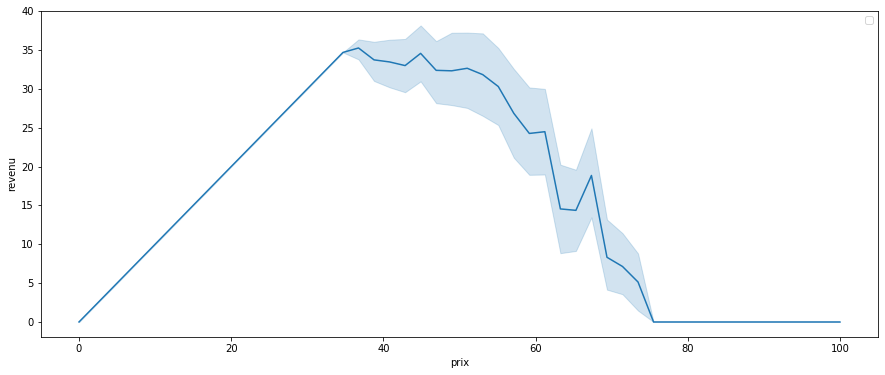

In [9]:
sim_u = UniformSimulation(35,75)
sim_u.optimal_price
plot_demand(sim_u,max_price = 100,n_estimates_per_point = 100)
#plt.title('Prix joués lors des 1000 derniers tirages par e-greedy')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('demand_uniform_20_60.png')



In [10]:
size = 7
k_p = np.linspace(5,120,size)


In [11]:
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)

BinomialBandit model instanciated with 7 arms.
43.333333333333336


In [12]:
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)
thompson_uniform_1=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=0,test_round=5000)
thompson_uniform_2=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=10,test_round=5000)


BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336


In [13]:
alpha_0 = np.repeat(0.25,size)
beta_0 = np.repeat(0.25,size)
thompson_uniform_3=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=0,test_round=5000)
thompson_uniform_4=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=10,test_round=5000)


BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336


In [14]:
alpha_0 = np.repeat(6,size)
beta_0 = np.repeat(6,size)
thompson_uniform_5=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=0,test_round=5000)
thompson_uniform_6=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=10,test_round=5000)

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336


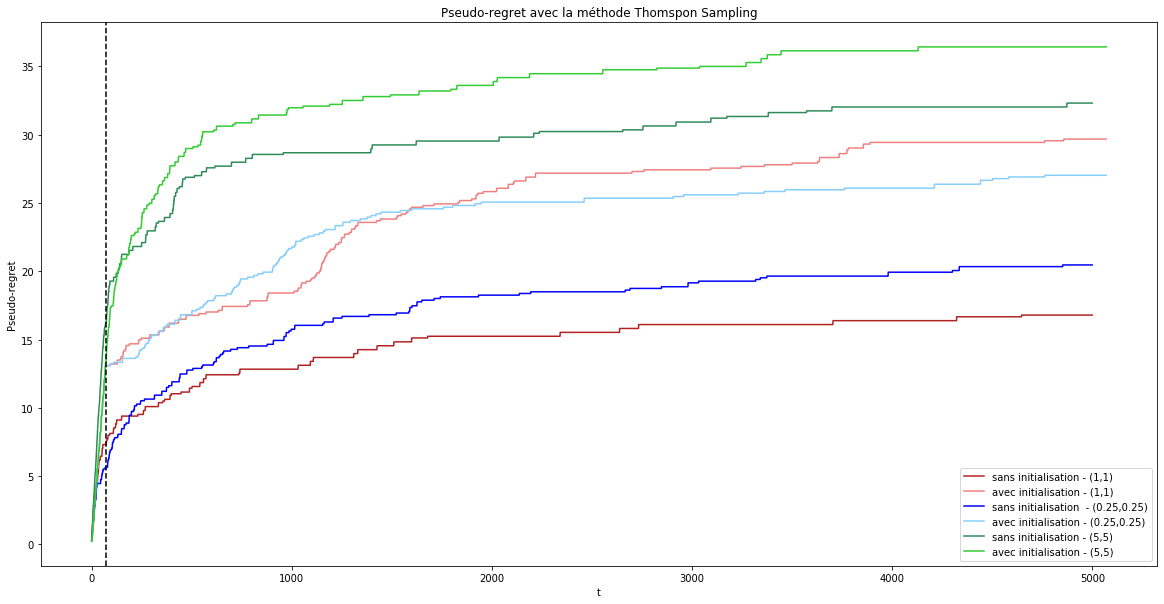

In [15]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(thompson_uniform_1[1],c='firebrick')
plt.plot(thompson_uniform_2[1],c='lightcoral')
plt.plot(thompson_uniform_3[1],c='blue')
plt.plot(thompson_uniform_4[1],c='lightskyblue')
plt.plot(thompson_uniform_5[1],c='seagreen')
plt.plot(thompson_uniform_6[1],c='limegreen')
plt.title('Pseudo-regret avec la méthode Thomspon Sampling')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=70,c='black',linestyle='dashed')
plt.legend(("sans initialisation - (1,1)","avec initialisation - (1,1)","sans initialisation  - (0.25,0.25)","avec initialisation - (0.25,0.25)","sans initialisation - (5,5)","avec initialisation - (5,5)"))
plt.savefig('thompson_uniform.png')

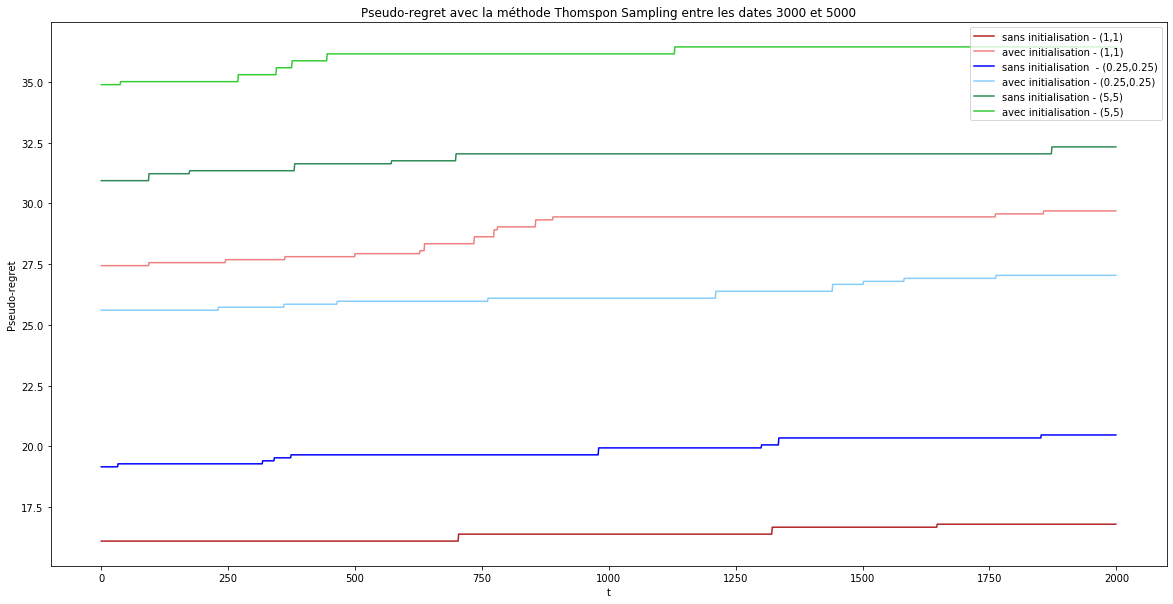

In [16]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(thompson_uniform_1[1][3000:5000],c='firebrick')
plt.plot(thompson_uniform_2[1][3000:5000],c='lightcoral')
plt.plot(thompson_uniform_3[1][3000:5000],c='blue')
plt.plot(thompson_uniform_4[1][3000:5000],c='lightskyblue')
plt.plot(thompson_uniform_5[1][3000:5000],c='seagreen')
plt.plot(thompson_uniform_6[1][3000:5000],c='limegreen')
plt.title('Pseudo-regret avec la méthode Thomspon Sampling entre les dates 3000 et 5000')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.legend(("sans initialisation - (1,1)","avec initialisation - (1,1)","sans initialisation  - (0.25,0.25)","avec initialisation - (0.25,0.25)","sans initialisation - (5,5)","avec initialisation - (5,5)"))
plt.savefig('thompson_uniform_reduced.png')

In [17]:
k_p

array([  5.        ,  24.16666667,  43.33333333,  62.5       ,
        81.66666667, 100.83333333, 120.        ])

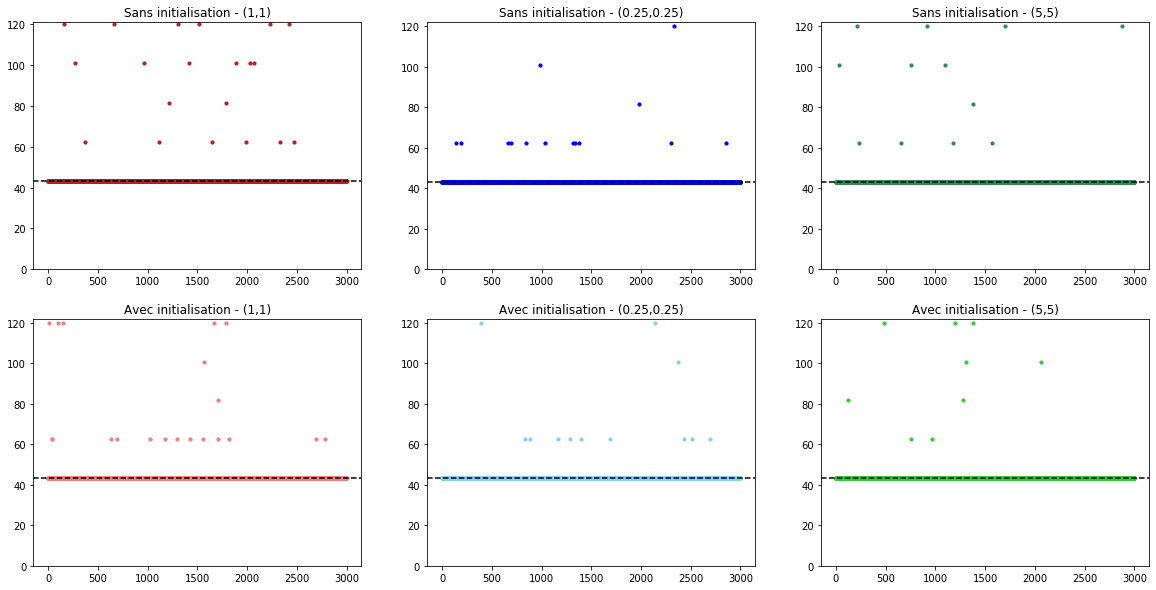

In [49]:
time=range(3000)
plt.title('Prix joués lors des 3000 derniers tirages')
plt.subplot(2,3,1)
plt.scatter(time,thompson_uniform_1[0][2000:5000],c='firebrick',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,121)
plt.title('Sans initialisation - (1,1)')
plt.subplot(2,3,2)
plt.scatter(time,thompson_uniform_3[0][2000:5000],c='blue',s=10)
plt.axhline(y=43.3333333333333368,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - (0.25,0.25)')
plt.subplot(2,3,3)
plt.scatter(time,thompson_uniform_5[0][2000:5000],c='seagreen',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - (5,5)')
plt.subplot(2,3,4)
plt.scatter(time,thompson_uniform_2[0][2000:5000],c='lightcoral',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - (1,1)')
plt.subplot(2,3,5)
plt.scatter(time,thompson_uniform_4[0][2000:5000],c='lightskyblue',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - (0.25,0.25)')
plt.subplot(2,3,6)
plt.scatter(time,thompson_uniform_6[0][2000:5000],c='limegreen',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - (5,5)')
plt.savefig('prix_th_uniform.png')

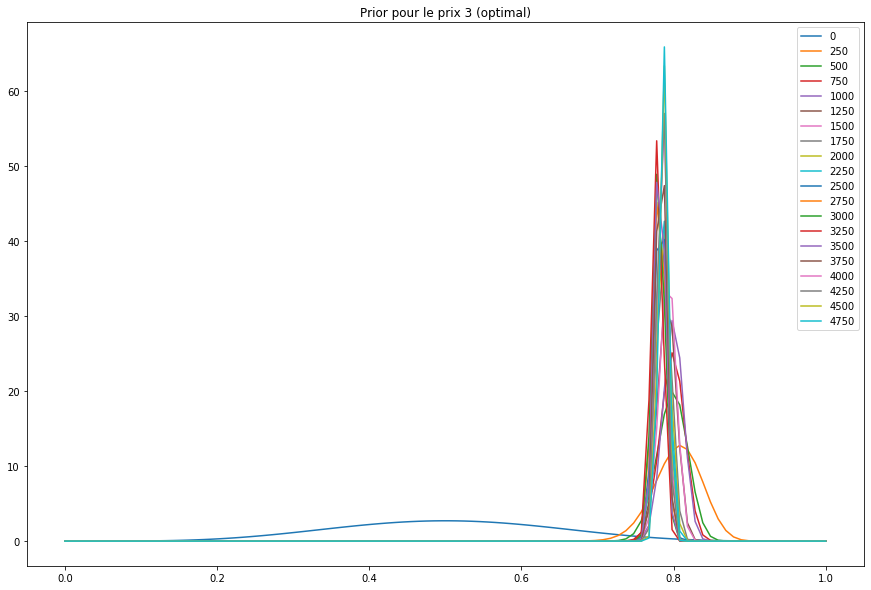

In [48]:
fig = plt.figure(figsize=(15,10), facecolor="w")
ax = plt.subplot()
for i in range(20):
    _alpha = thompson_uniform_1[2][0][i*250][2]
    _beta = thompson_uniform_1[2][1][i*250][2]
    plot_distrib_beta(_alpha,_beta, ax,label=i*250)
    i+=1
    ax.legend()
plt.title('Prior pour le prix 3 (optimal)')
plt.savefig('prior_uniform_opt_1.png')

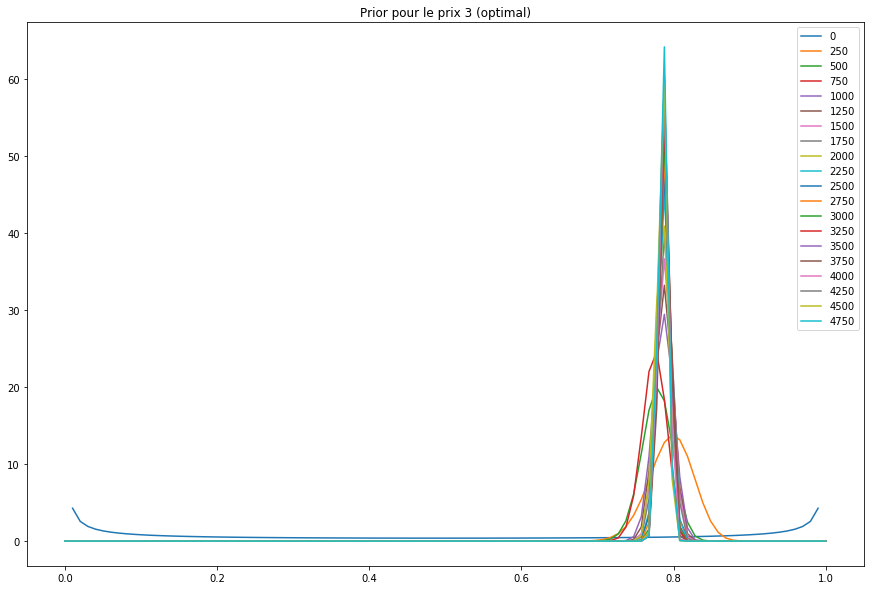

In [44]:
fig = plt.figure(figsize=(15,10), facecolor="w")
ax = plt.subplot()
for i in range(20):
    _alpha = thompson_uniform_3[2][0][i*250][2]
    _beta = thompson_uniform_3[2][1][i*250][2]
    plot_distrib_beta(_alpha,_beta, ax,label=i*250)
    i+=1
    ax.legend()
plt.title('Prior pour le prix 3 (optimal)')
plt.savefig('prior_uniform_opt_025.png')

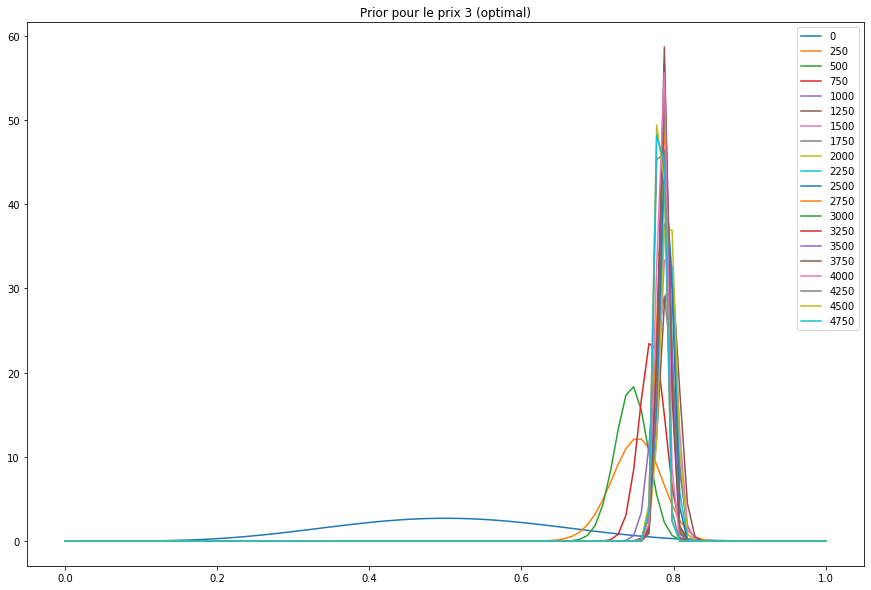

In [45]:
fig = plt.figure(figsize=(15,10), facecolor="w")
ax = plt.subplot()
for i in range(20):
    _alpha = thompson_uniform_5[2][0][i*250][2]
    _beta = thompson_uniform_5[2][1][i*250][2]
    plot_distrib_beta(_alpha,_beta, ax,label=i*250)
    i+=1
    ax.legend()
plt.title('Prior pour le prix 3 (optimal)')
plt.savefig('prior_uniform_opt_5.png')

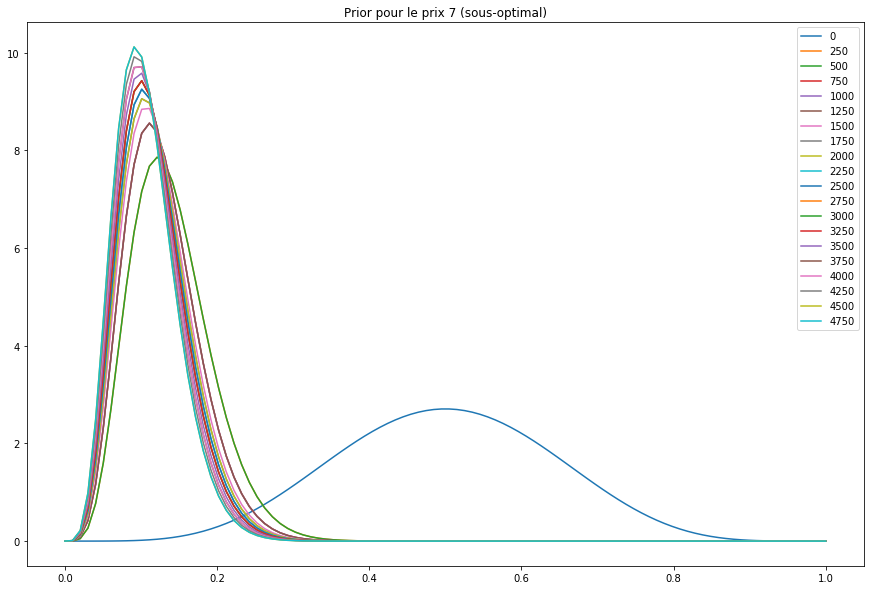

In [47]:
fig = plt.figure(figsize=(15,10), facecolor="w")
ax = plt.subplot()
for i in range(20):
    _alpha = thompson_uniform_1[2][0][i*250][6]
    _beta = thompson_uniform_1[2][1][i*250][6]
    plot_distrib_beta(_alpha,_beta, ax,label=i*250)
    i+=1
    ax.legend()
plt.title('Prior pour le prix 7 (sous-optimal)')
plt.savefig('prior_uniform_7_1.png')